VAEs dynamiques : https://arxiv.org/abs/2008.12595

# Comparing a Variational RNN and a Kalman Filter

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns

In [2]:
from libs.vrnn_lib import seed_everything, VRNN
from libs.vrnn_lib import loss_function, train
from libs.vrnn_lib import BetaLinearScheduler, BetaThresholdScheduler
from libs.vrnn_lib import plot_losses, sample_predictions

from pykalman import KalmanFilter

In [3]:
# Set seed for reproducibility
seed_everything(42)

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

print(f"Using {device}")

torch.set_default_dtype(torch.float64)

if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Using cuda
GPU Name: NVIDIA GeForce RTX 3080
Total GPU Memory: 9.8 GB


# Modèle

### Variational RNN :

The full factorization of $p(z_{1:T}, x_{1:T})$ is used:

\begin{align}
p(z_{1:T}, x_{1:T}) &= \prod_{t=1}^T p(z_t, x_t \vert z_{1:t-1}, x_{1:t-1}) \\
&= \prod_{t=1}^T p_{\theta_x}(x_t \vert x_{1:t-1}, z_{1:t}) p_{\theta_z}(z_t \vert z_{1:t-1}, x_{1:t-1}) \\
\end{align}

Where the two distributions $p_{\theta_z}$ and $p_{\theta_x}$ are Gaussians :

\begin{align}

p_{\theta_x}(x_t \vert x_{1:t-1}, z_{1:t}) &= \mathcal{N}(x_t \vert \mu_{\theta_x}(\overrightarrow{g}_{t-1}, h_{t}), \text{diag}(\sigma_{\theta_x}^{2}(\overrightarrow{g}_{t-1}, h_{t}))) \\
d_x(\overrightarrow{g}_{t-1}, h_{t}) &= [ \mu_{\theta_x}(\overrightarrow{g}_{t-1}, h_{t}), \sigma_{\theta_x}(\overrightarrow{g}_{t-1}, h_{t}) ] \\

p_{\theta_z}(z_t \vert z_{1:t-1}, x_{1:t-1}) &= \mathcal{N}(z_t \vert \mu_{\theta_z}(\overrightarrow{g}_{t-1}, h_{t-1}), \text{diag}(\sigma_{\theta_z}^{2}(\overrightarrow{g}_{t-1}, h_{t-1}))) \\
d_z(\overrightarrow{g}_{t-1}, h_{t-1}) &= [ \mu_{\theta_z}(\overrightarrow{g}_{t-1}, h_{t-1}), \sigma_{\theta_z}(\overrightarrow{g}_{t-1}, h_{t-1}) ] \\

\end{align}

où $d_x, d_z$ sont des MLP,

et où $h_t = \text{LSTM}(z_t, h_{t-1})$ est un forward LSTM qui encode $z_{1:t}$

et $\overrightarrow{g}_t = \text{LSTM}(x_t, \overrightarrow{g}_{t-1})$ est un forward LSTM qui encode $x_{1:t}$

### Modèle inférence

Le "true posterior" s'écrit :
\begin{align}
p_{\theta}(z_{1:T} \vert x_{1:T}) &= \prod_{t=1}^T p_{\theta} (z_t \vert z_{1:t-1}, x_{1:T} ) \\
\end{align}

où la première écriture est la stricte application de la chain rule.

On choisit comme approximation du posterior (=encodeur) une formulation calquée sur le vrai posterior :

\begin{align}
q_{\phi}(z_{1:T} \vert x_{1:T}) &= \prod_{t=1}^T q_{\phi} (z_{t} \vert z_{1:t-1}, x_{1:T}) \\
\end{align}

Et:
\begin{align}
q_{\phi} (z_{t} \vert z_{1:t-1}, x_{1:T}) &= \mathcal{N}(z_t \vert \mu_{\phi}(h_{t-1}, \overrightarrow{g}_{t-1}, \overleftarrow{g}_{t}), \text{diag} (\sigma_{\phi}^2(h_{t-1}, \overrightarrow{g}_{t-1}, \overleftarrow{g}_{t}))) \\
d_{\phi}(h_{t-1}, \overrightarrow{g}_{t-1}, \overleftarrow{g}_{t}) &= [ \mu_{\phi}(h_{t-1}, \overrightarrow{g}_{t-1}, \overleftarrow{g}_{t}), \sigma_{\phi}(h_{t-1}, \overrightarrow{g}_{t-1}, \overleftarrow{g}_{t}) ]
\end{align}

où $d_{\phi}$ est un MLP, et

$\overleftarrow{g}_t = \text{LSTM}(x_t, \overleftarrow{g}_{t-1})$ est un backward LSTM qui encode $x_{t:T}$

# Implémentation de l'inférence

Il y a ici quelques choix d'implémentations différents de ceux du papier originel:

- **trois** LSTMs distincts pour encoder $z_{1:t}$, $x_{1:t}$ et $x_{t:T}$

- pas d'extracteurs de features sur $x$ et $z$

# Training

Le modèle s'entraîne en maximisant un ELBO, dont la formulation dans le cas du VRNN est:

\begin{align}
    \begin{split}
    \mathcal{L}(\theta, \phi; X) &= \sum_{t=1}^T  \mathbb{E}{q_{\phi}(z_{1:t} \vert x_{1:T})} \log{p_{\theta_x}(x_t \vert x_{1:t-1}, z_{1:t})} \\ &- \sum_{t=1}^T \mathbb{E}{q_{\phi}(z_{1:t-1} \vert x_{1:T})} \mathbb{KL}{q_{\phi}(z_t \vert z_{1:t-1}, x_{1:T})}{p_{\theta_z}(z_t \vert z_{1:t-1}, x_{1:t-1})} 
    \end{split}    
\end{align}
<!-- 
Les deux termes s'explicitent de la façon suivante (avec $D$ dimension de l'espace des observations) :

\begin{align}
p_{\theta_x}(x_t \vert z_t) &= \mathcal{N}(x_t \vert \mu_{\theta_x}(z_t), \text{diag}(\sigma_{\theta_x}^2(z_t))) \\
\log{p_{\theta_x}(x_t \vert z_t)} &= -\frac{D}{2} \log{2\pi} - \frac{1}{2}\log{\vert \text{diag}(\sigma_{\theta_x}^2(z_t)) \vert} - 
\frac{1}{2} \left[ (x_t - \mu_{\theta_x}(z_t))^T (\text{diag}(\sigma_{\theta_x}^2(z_t)))^{-1} (x_t - \mu_{\theta_x}(z_t)) \right] \\
&= - \frac{1}{2} \left( \sum_{i=1}^D \log{\sigma_{\theta_x}^2(z_t)}\vert_{i} + (x_t - \mu_{\theta_x}(z_t))^T \text{diag} \frac{1}{\sigma_{\theta_x}^2(z_t)} (x_t - \mu_{\theta_x}(z_t)) + D \log{2\pi} \right)
\end{align}

Et la KL entre les deux Gaussiennes:

\begin{align}
q_\phi(z_t \vert z_{t-1}, x_{t:T}) &= \mathcal{N}(z_t \vert \mu_{\phi}(g_t), \text{diag}(\sigma_\phi^2(g_t))) \\
p_{\theta_z}(z_t \vert z_{t-1}) &= \mathcal{N}(z_t \vert \mu_{\theta_z}(z_{t-1}), \text{diag}(\sigma_{\theta_z}^{2}(z_{t-1}))) \\
\end{align}

a une close form (avec $Z$ dimension de l'espace latent):

\begin{align}
\text{D}_{\text{KL}}(q_\phi \vert\vert p_{\theta_z}) &= \frac{1}{2} \left[ \text{Tr}(\text{diag}(\sigma_{\theta_z}^{2})^{-1} \text{diag}(\sigma_\phi^2) ) + (\mu_{\theta_z} - \mu_\phi)^T (\text{diag}(\sigma_{\theta_z}^{2})^{-1}) (\mu_{\theta_z} - \mu_\phi) +
\log{\frac{\vert \text{diag}(\sigma_{\theta_z}^{2})\vert}{\vert \text{diag}(\sigma_\phi^2) \vert} } \right] \\
&= \frac{1}{2}\left[ \sum_{i=1}^Z \log{\sigma_{\theta_z}^{2}}\vert_i - \sum_{i=1}^Z \log{\sigma_{\phi}^{2}}\vert_i +
 (\mu_{\theta_z} - \mu_\phi)^T \text{diag}(\frac{1}{\sigma_{\theta_z}^{2}}) (\mu_{\theta_z} - \mu_\phi) + \sum_{i=1}^Z \frac{\sigma_{\phi}^{2}\vert_i} {\sigma_{\theta_z}^{2}\vert_i} - Z 
\right]
\end{align} -->

# Parameters

In [5]:
X_DIM = 1 # Dimension of the observation space
Z_DIM = 32 # Dimension of the latent space
RNN_X_H_DIM = 128 # Dimension of the hidden state of the bidirectional LSTM network for observations
RNN_Z_H_DIM = 128 # Dimension of the hidden state of the bidirectional LSTM network for latent variables

# Toy Case : Data Generation for Time Series Forecasting

In [6]:
n_steps = 20
n_ahead = 20
n_series = 100

def generate_time_series(batch_size, n_steps, noise=0.15):
    """Utility function to generate time series data.

    Args:
        batch_size (int): number of time series to generate (btach size)
        n_steps (_type_): length of each time series
    """
    
    f1,f2,o1,o2 = np.random.rand(4, batch_size, 1)  # return 4 values for each time series
    time = np.linspace(0, 1, n_steps)  # time vector
    
    series = 0.4 * np.sin((time - o1) * (f1 * 5 + 10)) # first sine wave
    series += 0.2 * np.sin((time - o2) * (f2 * 20 + 20)) # second sine wave
    series += noise * (np.random.randn(batch_size, n_steps) - 0.5)  # add noise
    
    return series

In [7]:
s = generate_time_series(n_series, n_steps+n_ahead)

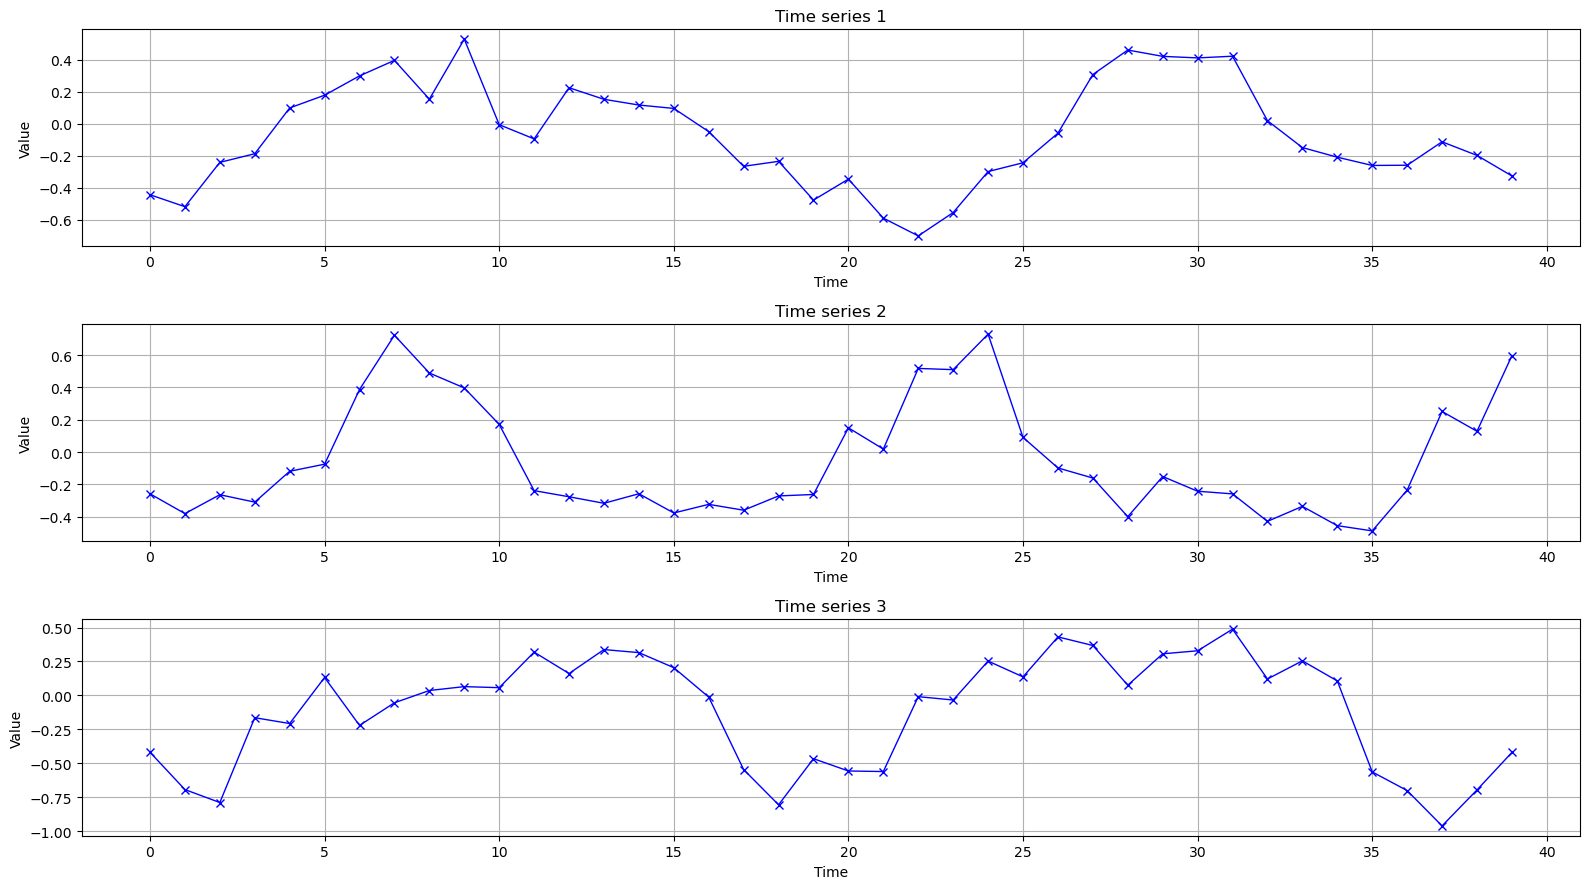

In [8]:
N = 3
fig, axs = plt.subplots(N, 1, figsize=(16, 3 * N))
for i in range(N):
    axs[i].plot(s[i], color='blue', marker="x", linewidth=1)
    axs[i].set_title(f"Time series {i+1}")
    axs[i].set_xlabel("Time")
    axs[i].set_ylabel("Value")
    axs[i].grid(True)
plt.tight_layout()
plt.show()

In [9]:
cutoff = int(0.8 * n_series)

X_train, y_train = s[:cutoff,:n_steps], s[:cutoff,n_steps:]
X_valid, y_valid = s[cutoff:,:n_steps], s[cutoff:,n_steps:]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_valid shape: {X_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")

X_train shape: (80, 20)
y_train shape: (80, 20)
X_valid shape: (20, 20)
y_valid shape: (20, 20)


In [10]:
# form datasets, dataloaders, etc

BATCH_SIZE = 8  # 8192 ok sur RTX3080 et 150 time steps

from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X).to(device)
        self.y = torch.tensor(y).to(device)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_valid, y_valid)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Training a VRNN

https://www.youtube.com/watch?v=rz76gYgxySo&list=WL&index=1&t=1618s&ab_channel=SimonLeglaive

<div>
<img src="/home/benjamin.deporte/MVA/MVA_Stage/vrnn3.jpg" width="1000"/>
</div>

In [11]:
X_DIM = 1 # Dimension of the observation space
Z_DIM = 32 # Dimension of the latent space
RNN_X_H_DIM = 128 # Dimension of the hidden state of the bidirectional LSTM network for observations
RNN_Z_H_DIM = 128 # Dimension of the hidden state of the bidirectional LSTM network for latent variables

In [12]:
vrnn = VRNN(
    input_dim = X_DIM,
    latent_dim = Z_DIM,
    rnn_x_hidden_dim = RNN_X_H_DIM,
    rnn_z_hidden_dim = RNN_Z_H_DIM,
    device=device
).to(device)

print(vrnn)

VRNN(observation_dim=1, latent_dim=32)
Bidirectional LSTM (input_size=1, rnn_x_hidden_size=128, num_layers=1)
Forward LSTM (input_size=32, rnn_z_hidden_size=128, num_layers=1)
Encoder MLP (z_dim=32, rnn_z_hidden_dim=128, rnn_x_hidden_dim=128)
Sequential(
  (0): Linear(in_features=384, out_features=16, bias=True)
  (1): Tanh()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): Tanh()
  (4): Linear(in_features=16, out_features=64, bias=True)
)
Latent State Transition MLP (z_dim=32, rnn_z_hidden_dim=128, rnn_x_hidden_dim=128)
Sequential(
  (0): Linear(in_features=256, out_features=16, bias=True)
  (1): Tanh()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): Tanh()
  (4): Linear(in_features=16, out_features=64, bias=True)
)
Decoder MLP (x_dim=1, rnn_z_hidden_dim=128, rnn_x_hidden_dim=128)
Sequential(
  (0): Linear(in_features=256, out_features=16, bias=True)
  (1): Tanh()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): Tanh()
  (4): Linear(in_

In [13]:
optimizer = torch.optim.Adam(vrnn.parameters(), lr=1e-3)
loss_fn = loss_function

# K is the number of samples to use for estimating the expectation over the posterior distribution
K = 5

In [14]:
num_epochs = 50
n_displays = 250
display_frequency = max(int(num_epochs / n_displays),1)

In [15]:
beta = 1.0

# beta_scheduler = BetaLinearScheduler(
#     beta_start=1e-3,
#     beta_end=1.0,
#     epoch_start=150,
#     epoch_end=200,
#     num_epochs=None
# )

# beta_scheduler = BetaThresholdScheduler(
#     rec_loss_threshold=0.0,
#     beta_start=1e-3,
#     beta_end=1.0,
#     num_epochs=20
# )

# print(beta_scheduler)

In [16]:
rec_losses, kl_losses, epoch_losses, val_rec_losses, val_kl_losses, val_epoch_losses, betas = train(
    vrnn, 
    optimizer, 
    loss_fn, 
    num_epochs=num_epochs, 
    train_loader=train_loader, 
    test_loader=test_loader, 
    batch_size=BATCH_SIZE, 
    device=device, 
    beta=beta,
    beta_scheduler=None, 
    display_frequency=display_frequency, 
    K=K
)

Starting training...
GPU Name: NVIDIA GeForce RTX 3080
Total GPU Memory: 9.8 GB
Number of epochs: 50
Learning rate: 1.000e-03
Batch size: 8
Beta scheduler: None, beta = 1.000e+00
K = 5
Training set size: 80
Validation set size: 20
Device: cuda


Epoch     1/50 with beta = 1.00e+00 - TRAINING : Rec Loss: 1.8020e-01, KL Loss: 1.4107e-01, Total Loss: 1.9133e+00 - TEST : Rec Loss: 6.0061e-01, KL Loss: 4.5966e-01, Total Loss: 1.5786e+00
Epoch     2/50 with beta = 1.00e+00 - TRAINING : Rec Loss: 1.6066e-01, KL Loss: 8.1559e-02, Total Loss: 1.3799e+00 - TEST : Rec Loss: 5.1284e-01, KL Loss: 2.6763e-01, Total Loss: 1.1750e+00
Epoch     3/50 with beta = 1.00e+00 - TRAINING : Rec Loss: 1.2436e-01, KL Loss: 5.2101e-02, Total Loss: 1.0517e+00 - TEST : Rec Loss: 3.9372e-01, KL Loss: 1.8573e-01, Total Loss: 8.7245e-01
Epoch     4/50 with beta = 1.00e+00 - TRAINING : Rec Loss: 1.0364e-01, KL Loss: 2.8059e-02, Total Loss: 7.8889e-01 - TEST : Rec Loss: 3.2942e-01, KL Loss: 1.0756e-01, Total Loss: 6.616

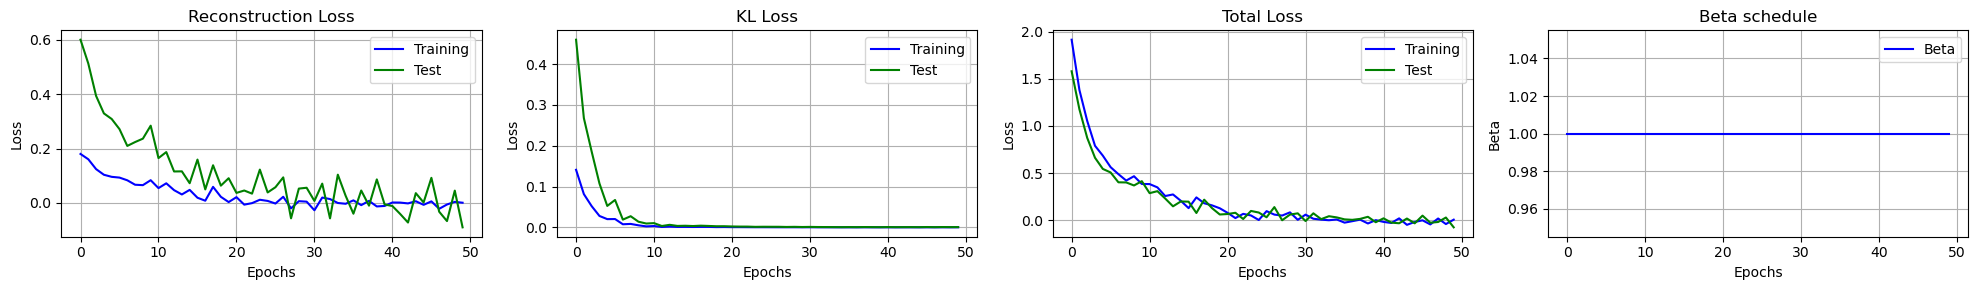

In [17]:
plot_losses(rec_losses, kl_losses, epoch_losses, val_rec_losses, val_kl_losses, val_epoch_losses, betas)

# Predictions / Générations

In [21]:
n_ahead = 20

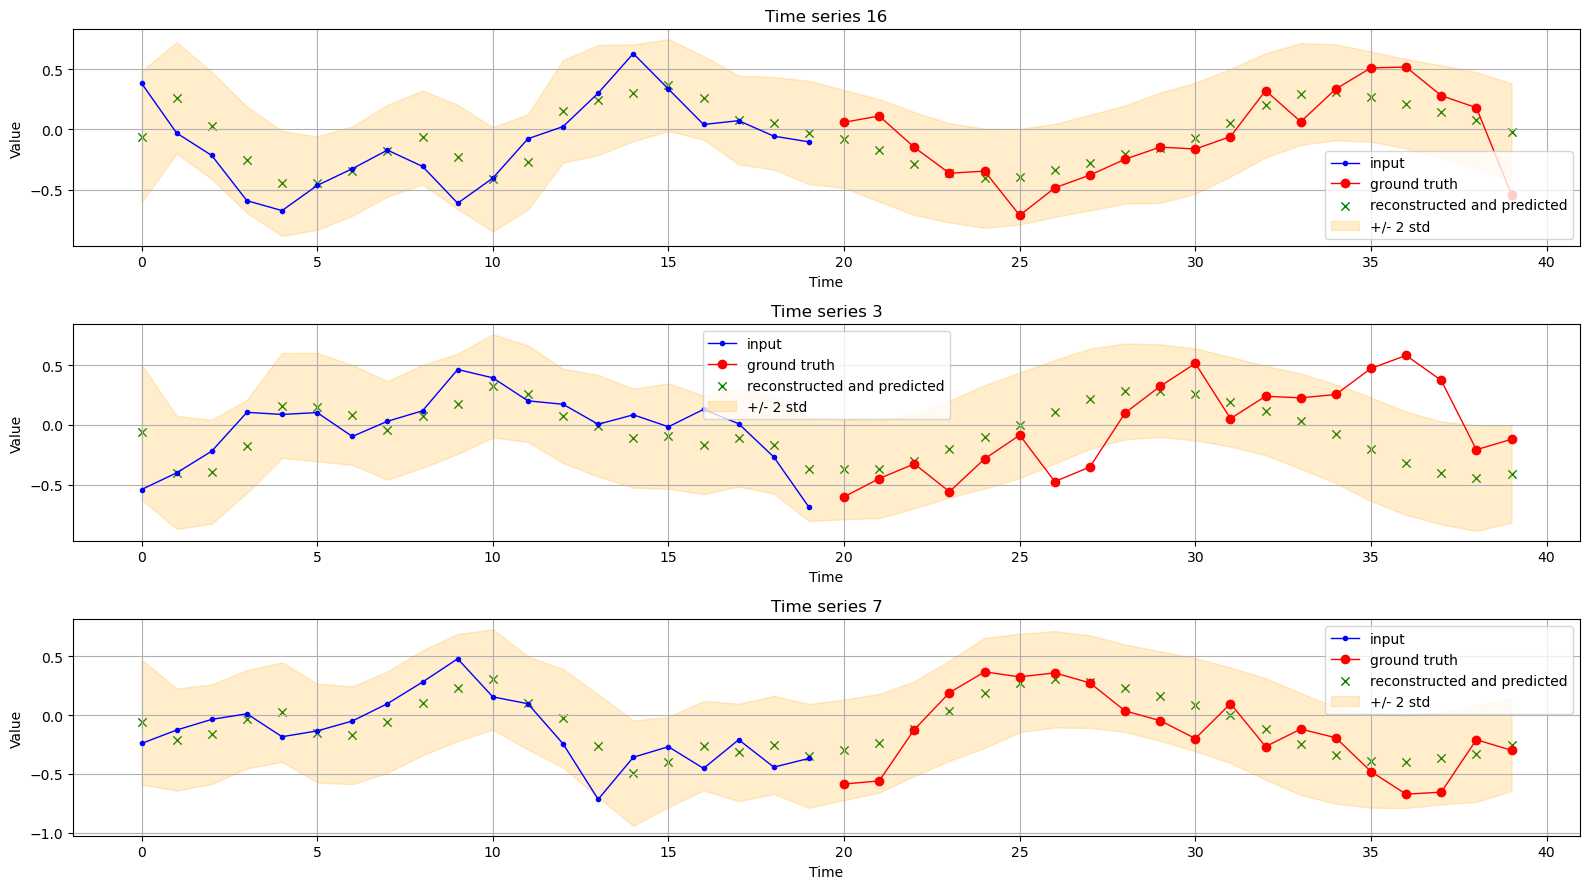

In [22]:
sample_predictions(N_SAMPLES=3, model=vrnn, X_valid=X_valid, y_valid=y_valid, n_steps=n_steps, n_ahead=n_ahead, device=device)

In [23]:
# computing the L2 loss on the test set
vrnn_past_mses = []
vrnn_predictions_mses = []
vrnn_reconstructions_mean = np.zeros((len(X_valid), n_steps))
vrnn_reconstructions_cov = np.zeros((len(X_valid), n_steps))
vrnn_predictions_mean = np.zeros((len(X_valid), n_ahead))
vrnn_predictions_cov = np.zeros((len(X_valid), n_ahead))

for i in range(len(X_valid)):
        input = torch.tensor(X_valid[i], device=device).unsqueeze(1).unsqueeze(2)
        mu_predictions, logvar_predictions, mu_full_x, logvar_full_x = vrnn.predict(input, n_ahead)
                     
        # compute predictions and credible intervals
        all_times = np.arange(n_steps+n_ahead)
        mu_full_x = mu_full_x.squeeze().cpu().detach().numpy()
        logvar_full_x = logvar_full_x.squeeze().cpu().detach().numpy()
        std_full_x = np.exp(logvar_full_x / 2)
        
        # log predictions
        vrnn_predictions_mean[i] = mu_full_x[n_steps:]
        vrnn_predictions_cov[i] = std_full_x[n_steps:]**2
        vrnn_reconstructions_mean[i] = mu_full_x[:n_steps]
        vrnn_reconstructions_cov[i] = std_full_x[:n_steps]**2
        
        # compute MSE for the past
        mse = (mu_full_x[:n_steps] - X_valid[i])**2
        # print(f"Time series {i+1} - MSE over past: {mse.mean():.6f}")
        vrnn_past_mses.append(mse.mean())
        # compute MSE for the future
        mse = (mu_full_x[n_steps:] - y_valid[i])**2
        # print(f"Time series {i+1} - MSE over prediction horizon: {mse.mean():.6f}")
        vrnn_predictions_mses.append(mse.mean())
        
print(f"VRNN : Average MSE over past: {np.mean(vrnn_past_mses):.3f} ± {np.std(vrnn_past_mses):.3f}")
print(f"VRNN : Average MSE over prediction horizon: {np.mean(vrnn_predictions_mses):.3f} ± {np.std(vrnn_predictions_mses):.3f}")

VRNN : Average MSE over past: 0.053 ± 0.017
VRNN : Average MSE over prediction horizon: 0.075 ± 0.042


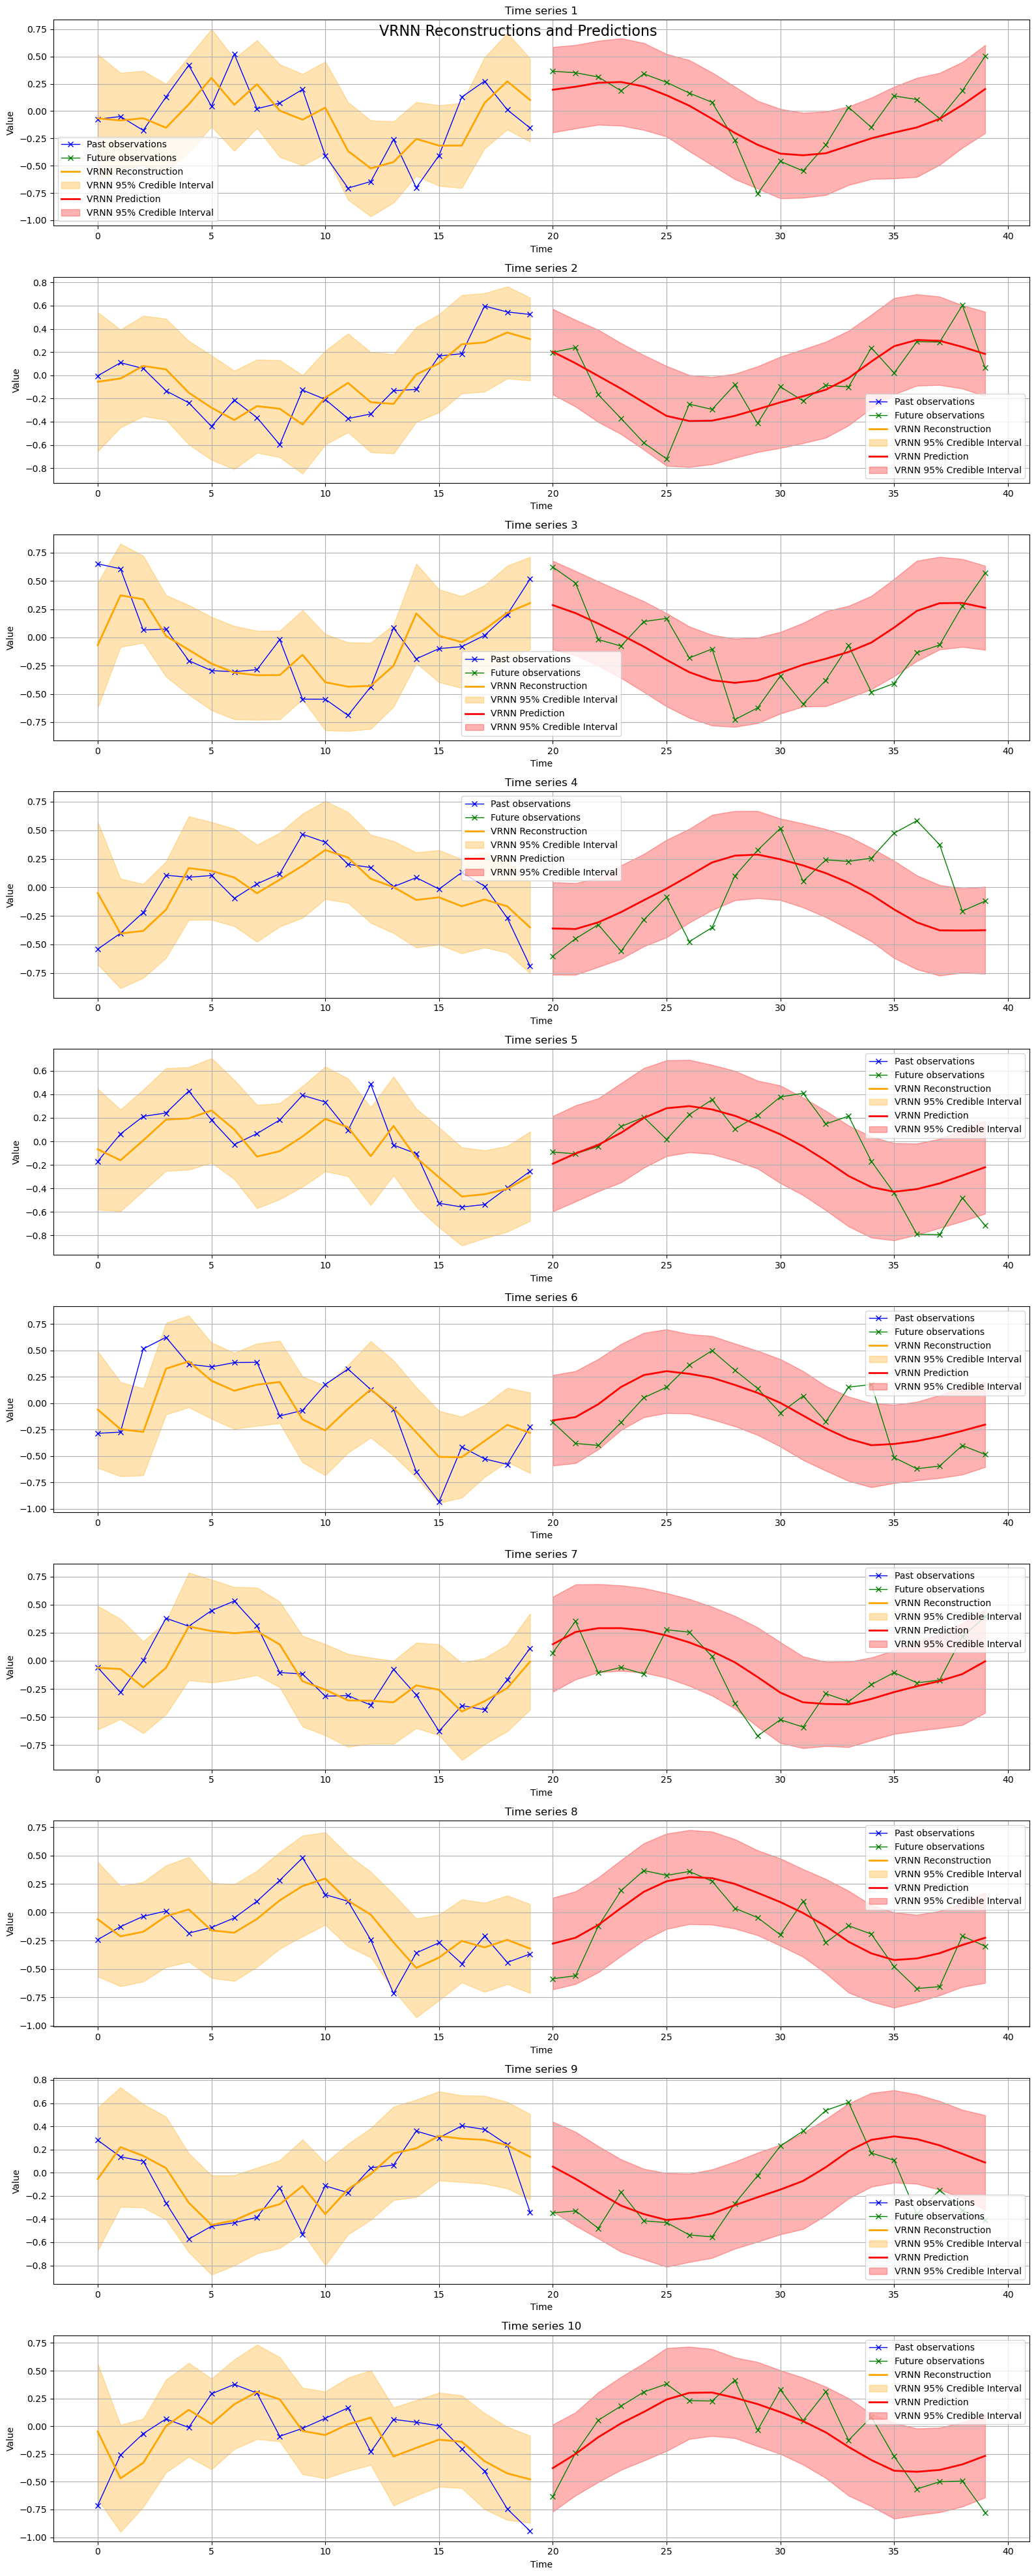

In [25]:
# plots
N_SAMPLES = 10

fig, axs = plt.subplots(N_SAMPLES, 1, figsize=(16, 4 * N_SAMPLES))
for i in range(N_SAMPLES):
    axs[i].plot(np.arange(n_steps), X_valid[i], color='blue', marker="x", linewidth=1, label="Past observations")
    axs[i].plot(np.arange(n_steps, n_steps+n_ahead), y_valid[i], color='green', marker="x", linewidth=1, label="Future observations")
    axs[i].plot(np.arange(n_steps), vrnn_reconstructions_mean[i], color='orange', linewidth=2, label="VRNN Reconstruction")
    axs[i].fill_between(np.arange(n_steps), 
                        vrnn_reconstructions_mean[i] - 1.96 * np.sqrt(vrnn_reconstructions_cov[i]),
                        vrnn_reconstructions_mean[i] + 1.96 * np.sqrt(vrnn_reconstructions_cov[i]),
                        color='orange', alpha=0.3, label="VRNN 95% Credible Interval")
    axs[i].plot(np.arange(n_steps, n_steps+n_ahead), vrnn_predictions_mean[i], color='red', linewidth=2, label="VRNN Prediction")
    axs[i].fill_between(np.arange(n_steps, n_steps+n_ahead), 
                        vrnn_predictions_mean[i] - 1.96 * np.sqrt(vrnn_predictions_cov[i]),
                        vrnn_predictions_mean[i] + 1.96 * np.sqrt(vrnn_predictions_cov[i]),
                        color='red', alpha=0.3, label="VRNN 95% Credible Interval")
    axs[i].set_title(f"Time series {i+1}")
    axs[i].set_xlabel("Time")
    axs[i].set_ylabel("Value")
    axs[i].legend()
    axs[i].grid(True)
    
fig.suptitle("VRNN Reconstructions and Predictions", fontsize=16)
plt.tight_layout()
plt.show()

# Training a basic Kalman Filter

In [28]:
# Paramètres pifométrés puis EM

# latent variable transition model
A = 0  # transition_offsetœ
B = 1  # transition_matrix
C = 100 # transition_covariance
s0 = 0  # initial_state_mean

# observation model
D = 1e2 # observation_covariance

kf = KalmanFilter(
    transition_matrices=[B],
    transition_offsets=[A],
    transition_covariance=C,
    observation_matrices=[1],
    observation_offsets=[0],
    observation_covariance=D,
    initial_state_mean=s0,
    initial_state_covariance=C,
)

In [29]:
# computing the L2 loss on the test set
kf_past_mses = []
kf_predictions_mses = []
kf_reconstructions_mean = np.zeros((len(X_valid), n_steps))
kf_reconstructions_cov = np.zeros((len(X_valid), n_steps))
kf_predictions_mean = np.zeros((len(X_valid), n_ahead))
kf_predictions_cov = np.zeros((len(X_valid), n_ahead))

for i in range(len(X_valid)):
    # get data
    measurements = np.asarray(X_valid)[i]
    # train the Kalman filter using EM one EACH time series
    kf = kf.em(measurements, n_iter=20)
    (filtered_state_means, filtered_state_covariances) = kf.filter(measurements)
    (smoothed_state_means, smoothed_state_covariances) = kf.smooth(measurements)
    
    # log reconstructions
    kf_reconstructions_mean[i] = smoothed_state_means.squeeze()
    kf_reconstructions_cov[i] = smoothed_state_covariances.squeeze()
    # measure L2 loss on the past
    mse = (smoothed_state_means.squeeze() - X_valid[i])**2
    # print(f"Time series {i+1} - Kalman Filter MSE over past: {mse.mean():.6f}")
    kf_past_mses.append(mse.mean())

    # compute predictions
    current_mean = smoothed_state_means[-1]
    current_covariance = smoothed_state_covariances[-1]
    predictions_mean = []
    predictions_covariance = []
    for j in range(n_ahead):
        next_mean, next_covariance = kf.filter_update(current_mean, current_covariance)
        predictions_mean.append(next_mean[0])
        predictions_covariance.append(next_covariance[0,0])
        current_mean = next_mean
        current_covariance = next_covariance
    predictions_mean = np.array(predictions_mean)
    predictions_covariance = np.array(predictions_covariance)
    
    # log predictions
    kf_predictions_mean[i] = predictions_mean
    kf_predictions_cov[i] = predictions_covariance
    # measure L2 loss on the future    
    mse = (predictions_mean.squeeze() - y_valid[i])**2
    # print(f"Time series {i+1} - Kalman Filter MSE over prediction horizon: {mse.mean():.6f}")
    kf_predictions_mses.append(mse.mean())
    
print(f"KF : Average MSE over past: {np.mean(kf_past_mses):.3f} ± {np.std(kf_past_mses):.3f}")
print(f"KF : Average MSE over prediction horizon: {np.mean(kf_predictions_mses):.3f} ± {np.std(kf_predictions_mses):.3f}")

KF : Average MSE over past: 0.020 ± 0.016
KF : Average MSE over prediction horizon: 0.210 ± 0.110


# Plotting stuff

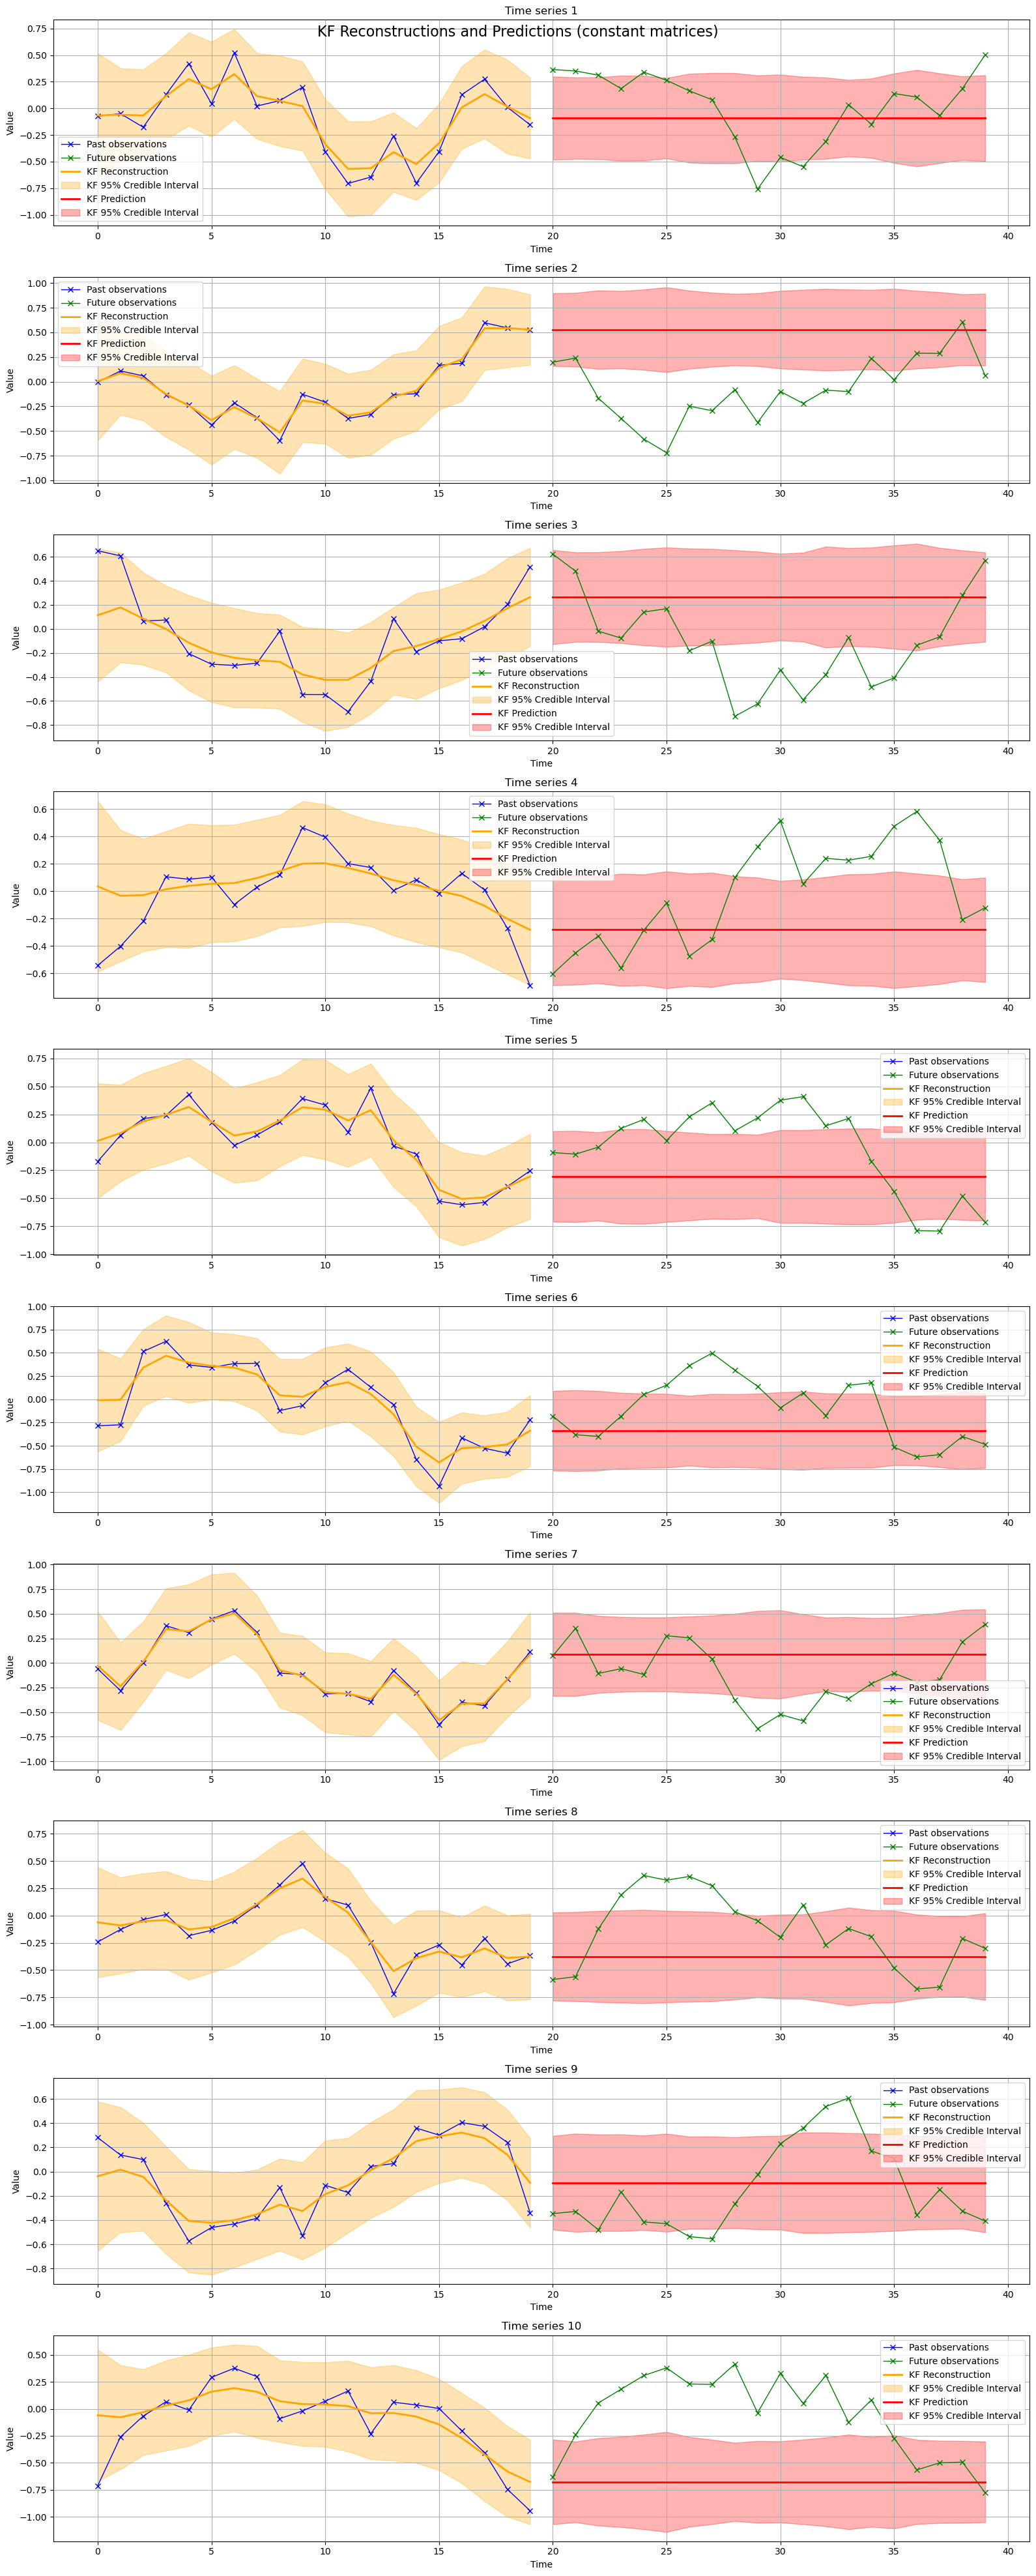

In [31]:
# plots
N = N_SAMPLES

fig, axs = plt.subplots(N_SAMPLES, 1, figsize=(16, 4 * N_SAMPLES))
for i in range(N_SAMPLES):
    axs[i].plot(np.arange(n_steps), X_valid[i], color='blue', marker="x", linewidth=1, label="Past observations")
    axs[i].plot(np.arange(n_steps, n_steps+n_ahead), y_valid[i], color='green', marker="x", linewidth=1, label="Future observations")
    axs[i].plot(np.arange(n_steps), kf_reconstructions_mean[i], color='orange', linewidth=2, label="KF Reconstruction")
    axs[i].fill_between(np.arange(n_steps), 
                        kf_reconstructions_mean[i] - 1.96 * np.sqrt(vrnn_reconstructions_cov[i]),
                        kf_reconstructions_mean[i] + 1.96 * np.sqrt(vrnn_reconstructions_cov[i]),
                        color='orange', alpha=0.3, label="KF 95% Credible Interval")
    axs[i].plot(np.arange(n_steps, n_steps+n_ahead), kf_predictions_mean[i], color='red', linewidth=2, label="KF Prediction")
    axs[i].fill_between(np.arange(n_steps, n_steps+n_ahead), 
                        kf_predictions_mean[i] - 1.96 * np.sqrt(vrnn_predictions_cov[i]),
                        kf_predictions_mean[i] + 1.96 * np.sqrt(vrnn_predictions_cov[i]),
                        color='red', alpha=0.3, label="KF 95% Credible Interval")
    axs[i].set_title(f"Time series {i+1}")
    axs[i].set_xlabel("Time")
    axs[i].set_ylabel("Value")
    axs[i].legend()
    axs[i].grid(True)
    
fig.suptitle("KF Reconstructions and Predictions (constant matrices)", fontsize=16)
plt.tight_layout()
plt.show()

# Plotting Reconstruction Losses

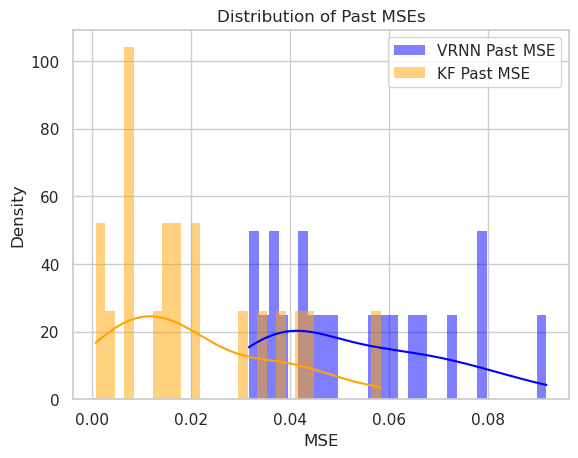

In [32]:
sns.set(style="whitegrid")

sns.histplot(vrnn_past_mses, color='blue', bins=30, label='VRNN Past MSE', kde=True, stat="density", linewidth=0)
sns.histplot(kf_past_mses, color='orange', bins=30, label='KF Past MSE', kde=True, stat="density", linewidth=0)
plt.title("Distribution of Past MSEs")
plt.xlabel("MSE")
plt.ylabel("Density")
plt.legend()
plt.show()